In [1]:
import numpy as np

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [4]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
jitter = 1e-8
gpr = GaussianProcessRegressor(kernel=rbf, alpha=jitter)

#### 실제 함수는 현재 sin 함수 기반

In [5]:
X_train = np.arange(-5,5,2.5).reshape(-1,1)
Y_train = np.sin(X_train) + jitter

In [6]:
X_train

array([[-5. ],
       [-2.5],
       [ 0. ],
       [ 2.5]])

In [7]:
X_true = np.linspace(-5,5,1000)
Y_true = np.sin(X_true) + jitter

In [8]:
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=1e-08, kernel=1**2 * RBF(length_scale=1))

In [9]:
X = np.arange(-5,5,0.2).reshape(-1,1)

In [10]:
# Computing posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov = True)

In [11]:
# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()["constant_value"])

In [12]:
import matplotlib.pyplot as plt
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

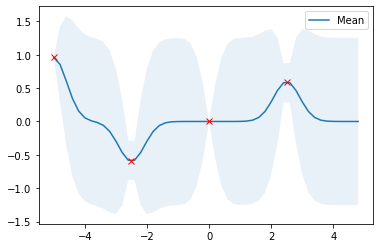

In [13]:
plot_gp(mu_s,cov_s, X, X_train=X_train, Y_train=Y_train)

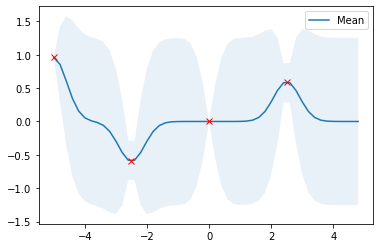

In [14]:
plot_gp(mu_s,cov_s, X, X_train=X_train, Y_train=Y_train)

In [167]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

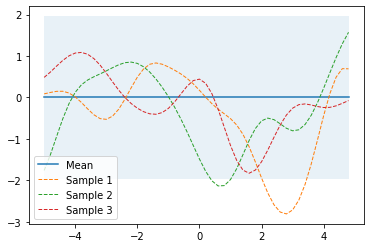

In [165]:
%matplotlib inline


# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [166]:
cov

array([[1.00000000e+00, 9.80198673e-01, 9.23116346e-01, ...,
        6.49934797e-20, 9.72098502e-21, 1.39694394e-21],
       [9.80198673e-01, 1.00000000e+00, 9.80198673e-01, ...,
        4.17501006e-19, 6.49934797e-20, 9.72098502e-21],
       [9.23116346e-01, 9.80198673e-01, 1.00000000e+00, ...,
        2.57675711e-18, 4.17501006e-19, 6.49934797e-20],
       ...,
       [6.49934797e-20, 4.17501006e-19, 2.57675711e-18, ...,
        1.00000000e+00, 9.80198673e-01, 9.23116346e-01],
       [9.72098502e-21, 6.49934797e-20, 4.17501006e-19, ...,
        9.80198673e-01, 1.00000000e+00, 9.80198673e-01],
       [1.39694394e-21, 9.72098502e-21, 6.49934797e-20, ...,
        9.23116346e-01, 9.80198673e-01, 1.00000000e+00]])

In [17]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

[[ 9.99999994e-09  0.00000000e+00  0.00000000e+00 ... -4.02523543e-22
  -2.54988519e-22 -1.48450460e-22]
 [ 1.11022302e-16  3.84270022e-02  7.34066732e-02 ... -6.82308615e-06
  -3.73427544e-06 -1.50013381e-06]
 [ 1.11022302e-16  7.34066732e-02  1.42980591e-01 ... -1.69846732e-05
  -9.29571274e-06 -3.73427544e-06]
 ...
 [ 6.23217640e-22 -6.82308615e-06 -1.69846732e-05 ...  2.85934498e-01
   2.00207982e-01  1.00802012e-01]
 [-6.20863527e-22 -3.73427544e-06 -9.29571274e-06 ...  2.00207982e-01
   1.42980591e-01  7.34066732e-02]
 [ 2.05515876e-21 -1.50013381e-06 -3.73427544e-06 ...  1.00802012e-01
   7.34066732e-02  3.84270022e-02]]


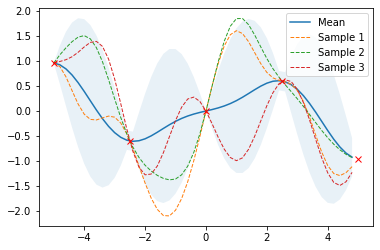

In [164]:
# Noise free training data
X_train = np.array([-5, -2.5, 0, 2.5, 5]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)
print(cov_s)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [40]:
from scipy import signal

In [136]:
def delta_func(x):
    return np.greater(x , -0.1) * np.less(x, 0.1) * (-3)
    

In [137]:
signal.unit_impulse(10,'mid') * 100

array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.])

[[ 9.80239180e-01  9.51525531e-01  8.83220679e-01 ... -2.61237101e-05
  -1.42722497e-05 -7.46813367e-06]
 [ 9.51525531e-01  9.58384805e-01  9.22277550e-01 ... -3.58332874e-05
  -1.95781133e-05 -1.02449921e-05]
 [ 8.83220679e-01  9.22277550e-01  9.19352419e-01 ... -4.63330348e-05
  -2.53168708e-05 -1.32488660e-05]
 ...
 [-2.61237101e-05 -3.58332874e-05 -4.63330348e-05 ...  9.99860961e-01
   9.80123707e-01  9.23077532e-01]
 [-1.42722497e-05 -1.95781133e-05 -2.53168708e-05 ...  9.80123707e-01
   9.99959593e-01  9.80177746e-01]
 [-7.46813367e-06 -1.02449921e-05 -1.32488660e-05 ...  9.23077532e-01
   9.80177746e-01  9.99989174e-01]]


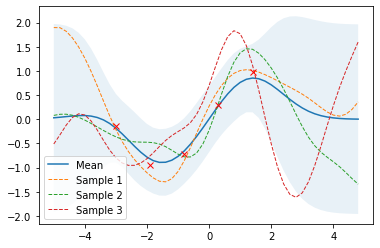

In [163]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 2, 1.1).reshape(-1, 1)
Y_train = np.sin(X_train) + delta_func(X_train)
#+ noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)
print(cov_s)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [151]:
delta_func(0)

-3

In [152]:
Y_train

array([[-0.14112001],
       [-0.94630009],
       [-0.71735609],
       [ 0.29552021],
       [ 0.98544973]])

In [153]:
X_train

array([[-3. ],
       [-1.9],
       [-0.8],
       [ 0.3],
       [ 1.4]])

In [154]:
X_true = np.linspace(-5,5,10000)
Y_true = np.sin(X_true) + delta_func(X_true)

In [155]:
X_true

array([-5.       , -4.9989999, -4.9979998, ...,  4.9979998,  4.9989999,
        5.       ])

In [ ]:
def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()   

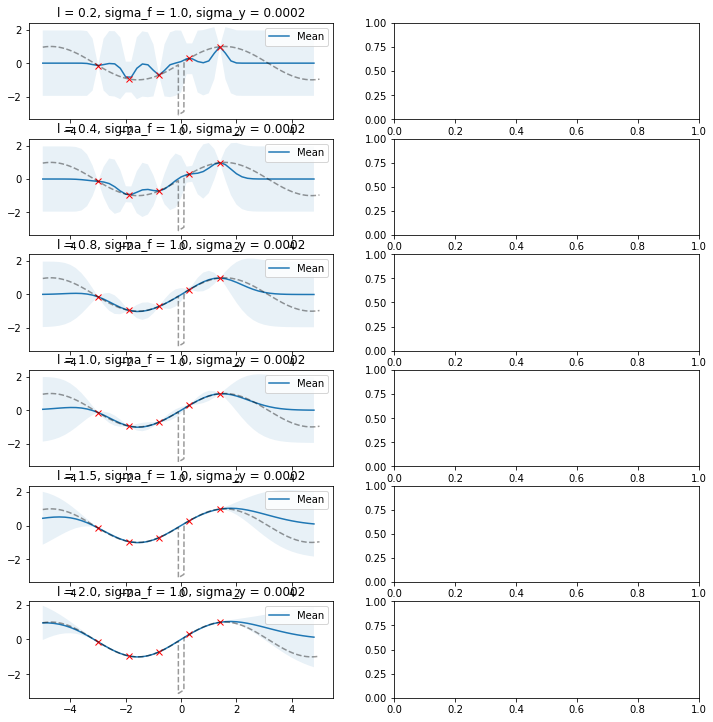

In [159]:
import matplotlib.pyplot as plt

params = [
    (0.2, 1.0, 0.0002),
    (0.4, 1.0, 0.0002),
    (0.8, 1.0, 0.0002),
    (1.0, 1.0, 0.0002),
    (1.5, 1.0, 0.0002),
    (2.0, 1.0, 0.0002),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    mu_sample_opt = np.max(Y_train)
    plt.subplot(len(params), 2, 2*i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
    plt.plot(X_true, Y_true,linestyle = '--' ,color='k', alpha = 0.4)
    
    plt.subplot(len(params), 2, 2*i + 2)
    

In [162]:
len(X)

50

In [161]:
len(cov_s)

50

여기서 prior 안 정했는데 어떻게 optimize 하지?

likelihood는 p(Data_n | hyperparameters) 이거 계산해서 미분, 그럼 posterior로 가보면 이 hyperparameter가 가장 많이 나온다는 말,
이 hyperparameter에 의한 acquisition function이 dominant 하게 될 것.

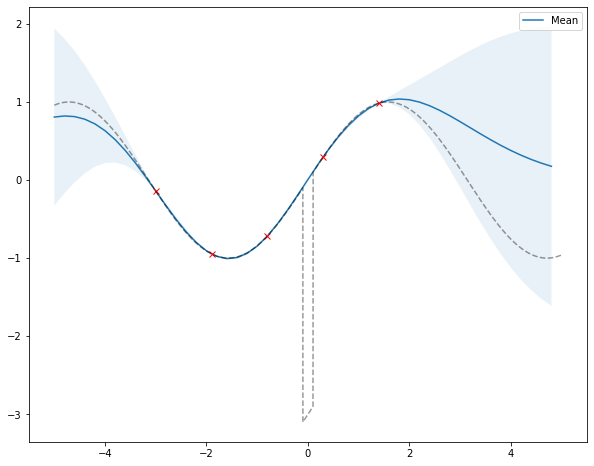

In [157]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.0002**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Plot the results
plt.figure(figsize=(10,8))
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
plt.plot(X_true, Y_true,linestyle = '--' ,color='k', alpha = 0.4)

In [158]:
print(l)
print(sigma_f)

1.8486130915123982
0.9809945201510442
